In [1]:
%config IPCompleter.greedy=True

In [2]:
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
local_dir = os.getcwd()
data_dir = join(local_dir,'data')
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')
train_data_path

'C:\\Users\\user00\\aiffel\\online2nd_pss\\exploration03\\data\\train.csv'

In [29]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [30]:
y = train['price']
y_log = np.log1p(train['price'])
del train['price']
del train['id']

In [31]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [32]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

test

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


<AxesSubplot:xlabel='price', ylabel='Density'>

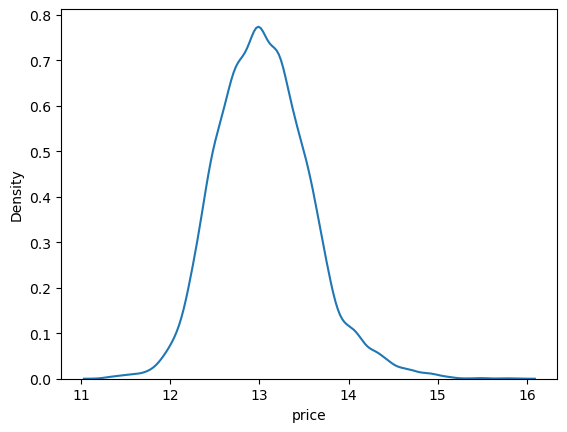

In [34]:
sns.kdeplot(y_log)

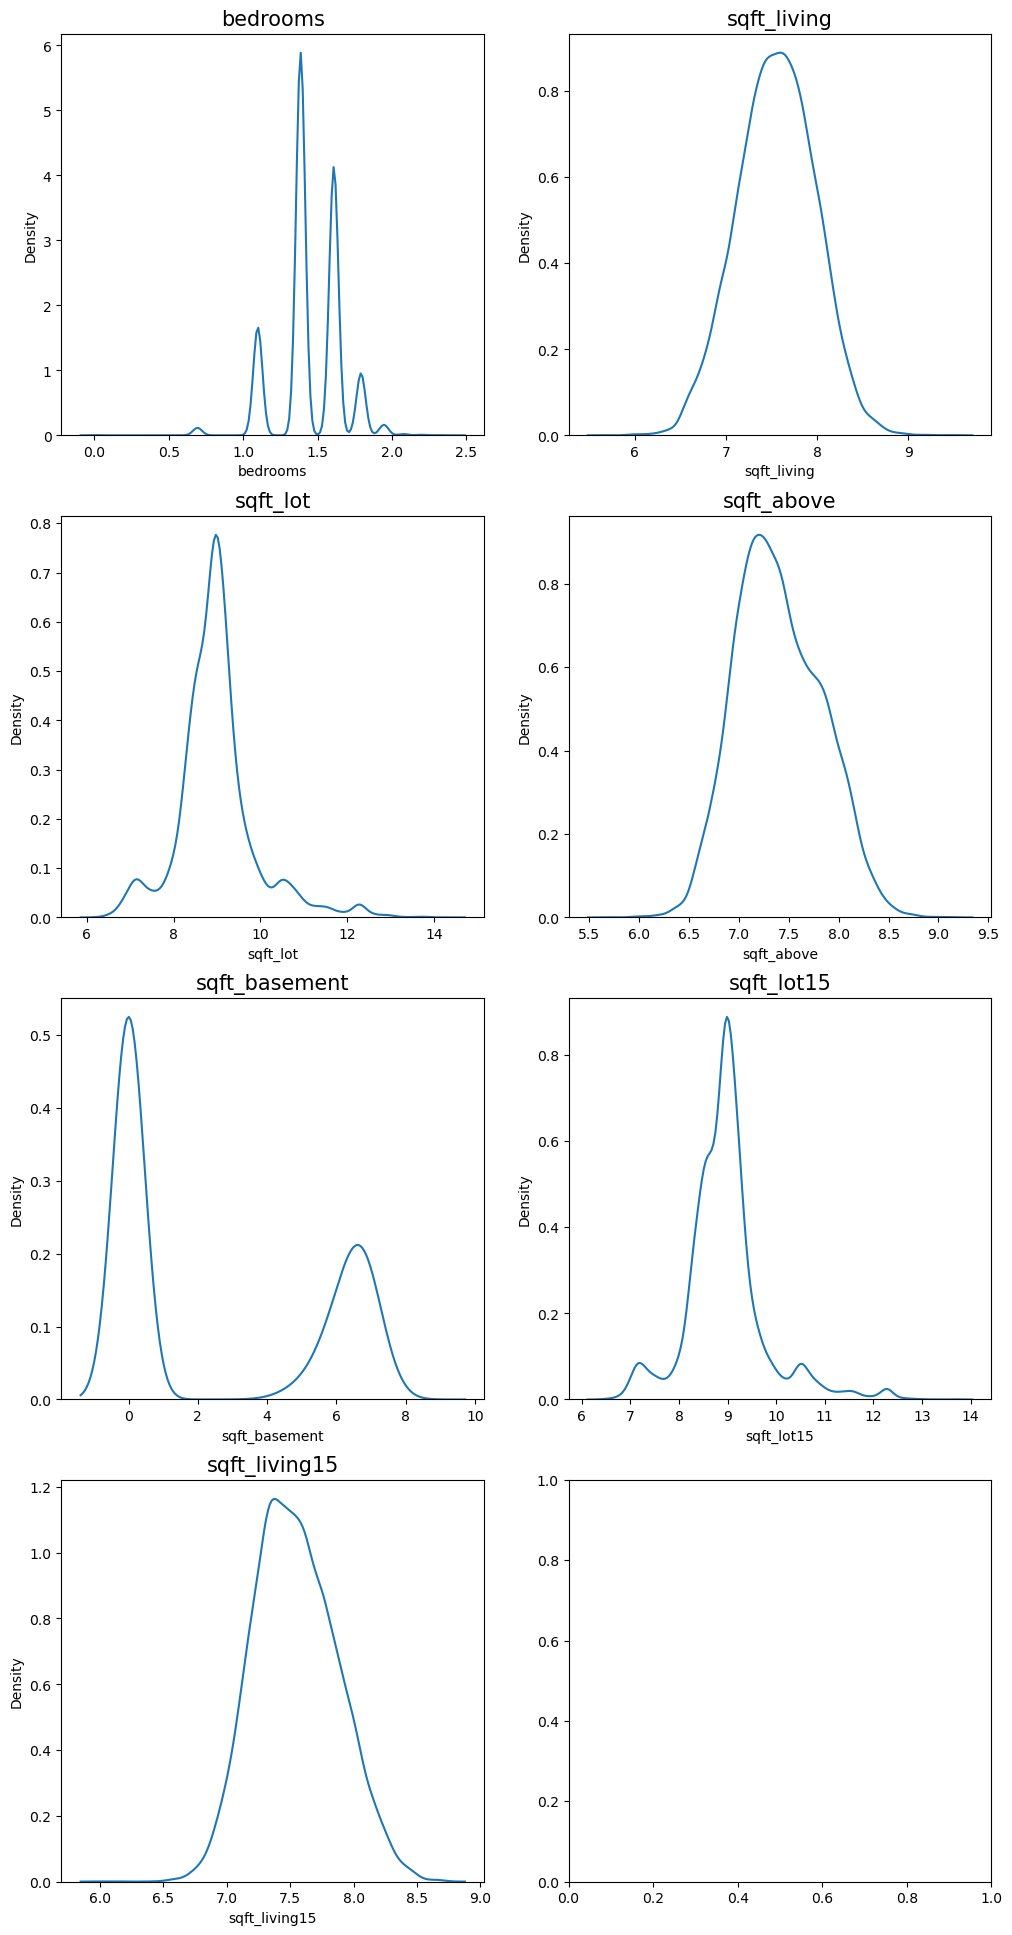

In [35]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [36]:
gboost = GradientBoostingRegressor(random_state=2022)
xgboost = XGBRegressor(random_state=2022)
lightgbm = LGBMRegressor(random_state=2022)
linear = LinearRegression()
rnd_forest = RandomForestRegressor(random_state=2022) 

voting_models = [
    ('lightgbm', lightgbm),
    ('xgboost', xgboost),
]

voting = VotingRegressor(voting_models, n_jobs=-1)

models = [gboost, xgboost, lightgbm, rnd_forest, voting]

In [37]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [44]:
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=2022, test_size=0.2)
voting.fit(X_train, y_train)

prediction = voting.predict(test)
prediction

array([1233326.77667958, 1349460.57820412, 1863171.19021396, ...,
       1638333.87638099, 1513172.4059833 , 1321447.52462874])

In [39]:
prediction = np.expm1(prediction)
prediction

array([1198096.75144896, 1067757.59391676, 1561175.5451223 , ...,
       1726054.54991884, 1626893.57557316, 1533243.51294321])

In [40]:
df = {}
random_state = 2022
for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y_log, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)
    
    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df    

{'GradientBoostingRegressor': 130363.5595581546,
 'XGBRegressor': 126719.52126933704,
 'LGBMRegressor': 120307.15535824456,
 'RandomForestRegressor': 136463.5011147285,
 'VotingRegressor': 119971.15833530486}

In [42]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [50]:


param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y_log, param_grid, verbose=2, n_jobs=5)
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

Fitting 5 folds for each of 4 candidates, totalling 20 fits


array([1115828.25454453,  955768.84408859, 2510027.25831722, ...,
       1472673.75865288, 1396890.42878638, 1243585.24544928])

In [106]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
my_submission_path = join(data_dir, 'submission.csv')
submission.to_csv(my_submission_path, index=False)
print('{} saved!')

{} saved!
